# Quick Start

We presently run through a simple example of how `kulprit` provides a simple and effective model selection procedure in the case of linear regression.

## Dependencies

To begin with, we import the necessary dependencies for the initial model fitting (for which we use `bambi`) and data handling. The `kulprit` package provides all the machinery for model selection once we have a fitting `bambi` model.

In [ ]:
#!pip install bambi git+https://github.com/yannmclatchie/kulprit.git

In [1]:
import pandas as pd
import numpy as np

import bambi as bmb
import kulprit as kpt

import arviz as az
import matplotlib.pyplot as plt

/Users/yannmclatchie/Desktop/kulprit/.venv/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Linear regression

### Data

To illustrate the use of `kulprit`, we begin with a linear regression. In this instance, we load some pre-generated data from `bambi`, and plot it.

In [2]:
# define model data
data = data = bmb.load_data("my_data")

Text(0.5, 1.0, 'Marginal of y in terms of z')

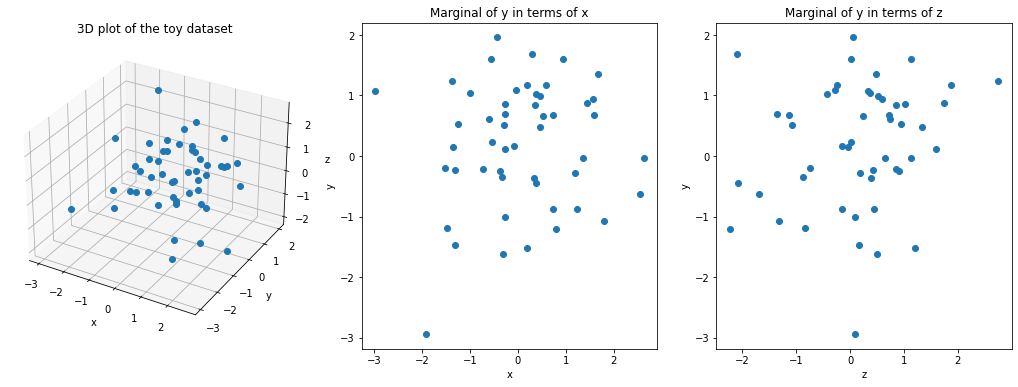

In [3]:
# plot the data
fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(1, 3, 1, projection="3d")
ax.plot(data["x"], data["y"], data["z"], "o")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("3D plot of the toy dataset")

ax = fig.add_subplot(1, 3, 2)
ax.plot(data["x"], data["y"], "o")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Marginal of y in terms of x")

ax = fig.add_subplot(1, 3, 3)
ax.plot(data["z"], data["y"], "o")
ax.set_xlabel("z")
ax.set_ylabel("y")
ax.set_title("Marginal of y in terms of z")

plt.show()


### The model

We presently look to fit a linear regression to these data, namely the model 
$$
z \sim \mathcal{N} (\beta_0 + \beta_1 x + \beta_2 y, \sigma)
$$
with $\sigma>0$ and $\beta_i \in \mathbb{R}$, in which we treat $z$ as our variate, and $x$ and $y$ as the covariates. This is cleanly communicated to `bambi` in the following formula, and we fit the model with Markov Chain Monte Carlo (MCMC) methods. We will use the default `bambi` priors over $\beta_i$ and $\sigma$, on which more information can be found in [the `bambi` docs](https://bambinos.github.io/bambi/main/index.html).

In [4]:
# define and fit model with MCMC
model = bmb.Model("y ~ x + z", data, family="gaussian")
num_draws, num_chains = 2_000, 2
idata = model.fit(draws=num_draws, chains=num_chains)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [y_sigma, z, x, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 30 seconds.


### Projection predictive model selection

We now perform the model selection procedure provided by `kulprit`. Importantly, we operate within a so-called $\mathcal{M}$-complete paradigm, in which we do not assume the existence of a true model, only a model that we believe to be well-suited to the task at hand, and which has past posterior checks. Out linear regression model is then considered as our _reference model_, and we look to identify subsets of its parameters that achieve similar predictive performance. To begin with, let us build this core `ReferenceModel` object from the `bambi` model.

In [5]:
# build reference model object
ref_model = kpt.ReferenceModel(model, idata)

From this, we perform a forward search through the parameter space starting with an intercept-only model. At each step, we "project" the reference model onto a given subset of parameters, and critique the predictive performance of this submodel. By projection, we concretely mean that for a reference model posterior $p(\boldsymbol y \mid \boldsymbol \beta^\ast)$ with $\boldsymbol \beta^\ast = (\beta_0, \beta_2, \beta_2)^T$, and a parameter subset $\boldsymbol \beta^\perp \subset \boldsymbol \beta^\ast$, we find the parameter values of $\boldsymbol \beta^\perp$ according to the solution to the optimisation problem
$$
\boldsymbol\beta^\perp = \arg\min_{\boldsymbol\beta} d\{ p(\boldsymbol y\mid \boldsymbol\beta),\, p(\boldsymbol y\mid \boldsymbol\beta^\ast) \}.
$$
In this formulation, $d\{\cdot, \cdot\}$ is the Kullback-Leibler distance metric. In a word, we look to achieve the values of $\boldsymbol \beta^\perp$ such that the posterior of their associated model is most close to the reference model. We leverage automatic differentiation to solve this optimisation problem, but in certain cases analytic solutions exist and can be used by setting the option `method="analytic"`.

Understanding this, we perform the complete forward search efficiently in `kulprit` as follows. More information regarding the projection predictive model selection paradigm can be found in [the following tutorial](projpred.ipynb).

In [24]:
ref_model.search(method="gradient")

                        Terms  Distance from reference model
Model size                                                  
0                 [Intercept]                       1.070913
1              [Intercept, z]                       1.032097
2           [Intercept, z, x]                       1.005195

Having performed the search, we have effectively generated a set of submodels according to a reference model. We find that the submodels generated increase in distance from the reference model with fewer number of parameters, as expected. It is now of interest to us to identify the one most closely resembling the reference model with the fewest parameters for parsimony. Given our focus on predictive performance, we do so by critiquing each of the submodels by their expected log-posterior density (ELPD) using leave-one-out cross-validation (LOO-CV). `kulprit` provides these tabular and graphic results easily with the `loo_compare` method.

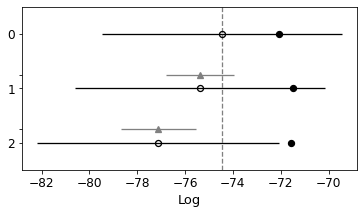

In [25]:
cmp, axes = ref_model.loo_compare(plot=True);

In [26]:
cmp

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
0,0,-74.457921,2.385010,0.000000,1.000000e+00,4.996276,0.000000,False,log
1,1,-75.372881,3.876921,0.914960,0.000000e+00,5.227423,1.420981,False,log
2,2,-77.125790,5.547887,2.667869,6.439294e-15,5.058074,1.562105,False,log


From these results, we migth reason that the difference in the ELPDs of the reference model and the model with only one parameter is not statistically significant, and thus we project our reference model onto this parameter subset easily as follows.

In [27]:
submodel = ref_model.project(1)
submodel.structure.term_names

['Intercept', 'z']

Note that we need not know the names of the parameters included in this submodel at the point of projection, but that we can easily extract them. Having achieved this submodel, we can more closely investigate the posterior distributions of its parameters alongside those of the reference mode model with `ArviZ`.

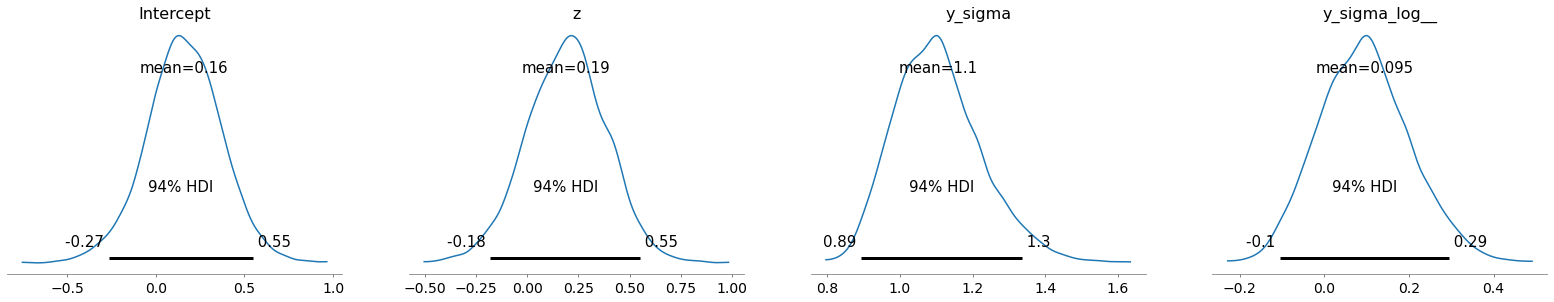

In [28]:
# visualise projected parameters
az.plot_posterior(submodel.idata);

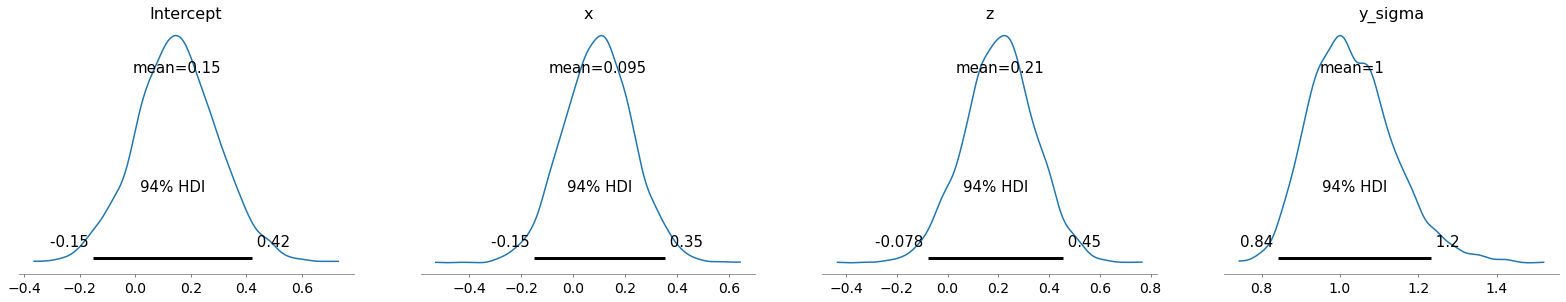

In [29]:
# compared to reference model
az.plot_posterior(idata, var_names=["Intercept", "x", "z", "y_sigma"]);

For more detailed explanations of the projection predictive model selection paradigm, and associated examples of `kulprit`, please visit the Tutorials section.